In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
import SimpleITK as sitk
# !{sys.executable} -m pip install seaborn --user
abs_dir="/mnt/data/mranzini"
# abs_dir="/Users/Marta/Desktop/mountpoint"
sys.path.append(os.path.join(*[abs_dir, "Code", "Demic-v0.1"]))
import pandas as pd
from Demic.util.image_process import *
# from Demic.image_io.file_read_write import *

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def compute_IoU(seg1, seg2, label=1.0, display_counters=False):
    """
    computes intersection over union as TP/(TP + FP + FN)
    inputs
        - seg1: first segmentation mask 
        - seg2: second segmentation mask to compare to first
        - label: which label to compute the iou for
    output:
        - iou: intersection over union
    """

    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = (seg1 == label)
    yp = (seg2 == label)

    TP = np.sum(np.logical_and(yt == 1, yp == 1))  # True positives
    TN = np.sum(np.logical_and(yt == 0, yp == 0))  # True negatives
    FP = np.sum(np.logical_and(yt == 0, yp == 1))  # False positives
    FN = np.sum(np.logical_and(yt == 1, yp == 0))  # False negatives
    
    iou = TP / (TP + FP + FN)
    
    if display_counters:
        print('TP = ' + str(TP))
        print('TN = ' + str(TN))
        print('FP = ' + str(FP))
        print('FN = ' + str(FN))
        print('IoU = ' + str(iou))

    return iou

In [3]:
# Guotai's implementation
def binary_iou(s, g):
    assert(len(s.shape)== len(g.shape))
    intersecion = np.multiply(s, g)
    union = np.asarray(s + g >0, np.float32)
    iou = intersecion.sum()/(union.sum() + 1e-10)
    return iou


In [4]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
    
    return dice 

In [5]:
# quick test iou makes sense
A = np.array([[1, 2, 2, 1], [2, 2, 2, 1], [4, 5, 2, 1], [8, 2, 4, 2]])
# print(A)
B = np.array([[2, 2, 2, 2], [1, 1, 1, 1], [1, 2, 2, 1], [8, 2, 2, 2]])
# print(B)

# for class = 2
# expected: TP = 5; TN = 4; FP = 4; FN = 3; => IoU = 0.41666667
IoU = compute_IoU(A, B, label=2, display_counters=True)
IoU_guotai = binary_iou(s=(A==2), g=(B==2))
print(IoU_guotai)

dice = compute_dice(A, B, label=2)
# expected: 10/17 = 0.588 
print(dice)

TP = 5
TN = 4
FP = 4
FN = 3
IoU = 0.4166666666666667
0.41666666666319446
0.588235294114187


In [13]:
def get_weighted_largest_component(img, weight_map, thr_map=0.5): # 2D or 3D
    if(img.sum()==0):
        print('the largest component is null')
        return img
    if(len(img.shape) == 3):
        s = ndimage.generate_binary_structure(3,1) # iterate structure
    elif(len(img.shape) == 2):
        s = ndimage.generate_binary_structure(2,1) # iterate structure
    else:
        raise ValueError("the dimension number shoud be 2 or 3")
    labeled_array, numpatches = ndimage.label(img,s) # labeling
    sizes = ndimage.sum(img,labeled_array,range(1,numpatches+1))
    weights = ndimage.sum(weight_map,labeled_array,range(1,numpatches+1))
    max_label = np.where(sizes == sizes.max())[0] + 1
    max_label = np.where(weights == weights.max())[0] + 1
#     # tentativo
#     binary_map = weight_map > thr_map
#     labeled_map, numpatches_map = ndimage.label(binary_map,s)
#     weights = ndimage.sum(weight_map,labeled_map,range(1,numpatches_map+1))
#     max_label_map = np.where(weights == weights.max())[0] + 1
#     # set to zero weights outside the max_label_map
#     weight_map[labeled_map != max_label_map] = 0
#     final_weights = ndimage.sum(weight_map,labeled_array,range(1,numpatches+1))
#     max_label =  np.where(final_weights == final_weights.max())[0] + 1
#     print(max_label)
    return np.asarray(labeled_array == max_label, np.uint8), labeled_array

In [14]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

In [15]:
def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    # if two channels, get the foreground one
    if img.shape[3] > 1:
        img = img[..., 1]
        
    return img

In [16]:
def get_all_dice(group="GroupA", remove_outliers=False):

    MAIN_DIR = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Retraining_with_expanded_dataset"])
    folder_segment_guotai = os.path.join(*[MAIN_DIR, "inference", "guotai"])
    folder_segment_retrained = os.path.join(*[MAIN_DIR, "inference", "expanded"])
#     folder_unet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
#                                 "basic_unet_monai", "runs", "2020-04-28_18-54-11", "inference_with_postprocessing"])
#     folder_unet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
#                                 "basic_unet_monai", "tests_deterministic_seeds", "2020-06-19_15-36-56_plot_gradient_norm_clipping2", 
#                                  "inference_with_postprocessing"])
#     folder_unet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
#                                 "basic_unet_monai", "tests_deterministic_seeds", "2020-07-02_22-50-00_MONAI_unet_Xent_10000", 
#                                  "inference_with_postprocessing"])
#     folder_unet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
#                                 "basic_unet_monai", "tests_deterministic_seeds", "2020-07-09_15-26-42_MONAI_unet_Dice_twochannel_smooth1e-5", 
#                                  "inference_no_postprocessing"])
    folder_unet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                                "basic_unet_monai", "tests_deterministic_seeds", "2020-07-06_14-08-14_MONAI_unet_Dice_nosmooth_it10000", 
                                 "inference_no_postprocessing"])
#     folder_unet_3D = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
#                                 "basic_unet_monai", "tests_3D_unet", "2020-07-27_16-21-06_CustomUnet25_Dice_inplaneResize_outplaneCrop", 
#                                  "inference_net_key_metric=0.7845"])
    folder_unet_3D = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                                "basic_unet_monai", "tests_3D_unet", "2020-07-29_14-43-38_ShallowUNet_Dice_inplaneResize_outplaneCrop", 
                                 "inference_valid_key_metric=0.6984"])

    folder_gt1 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset"])
    folder_gt2 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset_extension"])

    params_dict = {'GroupA': os.path.join(folder_gt1, "list_inference_h_subjects.txt"),
                  'GroupB1': os.path.join(folder_gt1, "list_inference_p1_subjects.txt"),
                  'GroupB2': os.path.join(folder_gt1, "list_inference_p2_subjects.txt"),
                  'GroupC': os.path.join(*[folder_gt2, "splitting_list", "list_inference_C.txt"]),
                  'GroupD': os.path.join(*[folder_gt2, "splitting_list", "list_inference_D.txt"]),
                  'GroupE': os.path.join(*[folder_gt2, "splitting_list", "list_inference_E.txt"]),
                  'GroupF': os.path.join(*[folder_gt2, "splitting_list", "list_inference_F.txt"])
                  }
    
    gt_dict = {'GroupA': folder_gt1,
               'GroupB1': folder_gt1,
               'GroupB2': folder_gt1,
               'GroupC': folder_gt2,
               'GroupD': folder_gt2,
               'GroupE': folder_gt2,
               'GroupF': folder_gt2}

    dice_vals = {"subj_id": [], "guotai": [], "expanded": [], "basic_unet": [], "combine_unet": []}
    subj_list = params_dict[group]
    folder_gt = gt_dict[group]
    with open(subj_list) as r:
        lines = r.readlines()
        for l in lines:
            print(l)
            all_stacks = sorted(glob.glob(os.path.join(*[folder_gt, group, l.rstrip() + '*_Label.nii.gz'])))
            for s in all_stacks:
                scan_id = os.path.basename(s)
                scan_id = scan_id.split("_Label", 1)[0]
                if scan_id == "b79_16":
                    # original image is corrupted
                    continue
                dice_vals["subj_id"].append(scan_id)
                
                # get the ground truth
                gt = np.squeeze(read_nifti(s))
                
                # extract dice from Guotai's model
                guotai_file = os.path.join(*[folder_segment_guotai, group, scan_id + "_segment.nii.gz"])
                guotai_segment = np.squeeze(read_nifti(guotai_file))
                if(remove_outliers):
                    strt = ndimage.generate_binary_structure(3,2) # iterate structure
                    post_guotai = ndimage.morphology.binary_closing(guotai_segment, strt)
                    post_guotai = get_largest_component(post_guotai)
                    guotai_segment = np.asarray(post_guotai*guotai_segment, np.uint8)
                dice_vals["guotai"].append(compute_dice(gt, guotai_segment))
                
                # extract dice from expanded training model
                retrained_file = os.path.join(*[folder_segment_retrained, group, scan_id + "_segment.nii.gz"])
                retrained_segment = np.squeeze(read_nifti(retrained_file))
                if(remove_outliers):
                    strt = ndimage.generate_binary_structure(3,2) # iterate structure
                    post_retrained = ndimage.morphology.binary_closing(retrained_segment, strt)
                    post_retrained = get_largest_component(post_retrained)
                    retrained_segment = np.asarray(post_retrained*retrained_segment, np.uint8)
                dice_vals["expanded"].append(compute_dice(gt, retrained_segment))
                
                # extract dice from basic unet in monai
                monai_file = os.path.join(*[folder_unet, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
                monai_segment = np.squeeze(read_nifti(monai_file))

                if(remove_outliers):
                    strt = ndimage.generate_binary_structure(3,2) # iterate structure
                    post_monai = ndimage.morphology.binary_closing(monai_segment, strt)
                    post_monai = get_largest_component(post_monai)
                    monai_segment = np.asarray(post_monai*monai_segment, np.uint8)
                dice_vals["basic_unet"].append(compute_dice(gt, monai_segment))
                
                # extract dice from 2D + 3D Unet in MONAI
                file_2D = os.path.join(*[folder_unet, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
                file_2D_segment = np.squeeze(read_nifti(file_2D))
                
                file_3D = os.path.join(*[folder_unet_3D, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
                file_3D_segment = np.squeeze(read_nifti(file_3D))
                file_3D_segment[file_3D_segment < 0.1] = 0.0
                
#                 combine_segment = file_2D_segment * file_3D_segment
                if(remove_outliers):
                    strt = ndimage.generate_binary_structure(3,2) # iterate structure
                    post_combine = ndimage.morphology.binary_closing(file_2D_segment, strt)
                    post_combine, _ = get_weighted_largest_component(post_combine, file_3D_segment)
                    combine_segment = np.asarray(post_combine*file_2D_segment, np.uint8)
                dice_vals["combine_unet"].append(compute_dice(gt, combine_segment))  

    dice_vals["guotai"] = np.asarray(dice_vals["guotai"])
    dice_vals["expanded"] = np.asarray(dice_vals["expanded"])
    dice_vals["basic_unet"] = np.asarray(dice_vals["basic_unet"])
    dice_vals["combine_unet"] = np.asarray(dice_vals["combine_unet"])

    return dice_vals

In [ ]:
# test weighted largest connected component
file_2D = "/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds/" \
            "2020-07-06_14-08-14_MONAI_unet_Dice_nosmooth_it10000/inference_no_postprocessing/" \
            "a26_06_Image/a26_06_Image_seg.nii.gz"
file_3D = "/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/" \
            "2020-07-27_16-21-06_CustomUnet25_Dice_inplaneResize_outplaneCrop/inference_net_key_metric=0.7845/" \
            "a26_06_Image/a26_06_Image_seg.nii.gz"
file_2D_segment = np.squeeze(read_nifti(file_2D))
file_3D_segment = np.squeeze(read_nifti(file_3D))
file_3D_segment[file_3D_segment < 0.1] = 0.0

strt = ndimage.generate_binary_structure(3,1) # iterate structure
post_combine = ndimage.morphology.binary_closing(file_2D_segment, strt)

max_label, all_labels = get_weighted_largest_component(post_combine, file_3D_segment)

outdir = "/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/tmp_prova_connected_components"
img_ref = sitk.ReadImage(file_2D)
max_label_nii = sitk.GetImageFromArray(max_label)
max_label_nii.CopyInformation(img_ref)
sitk.WriteImage(max_label_nii, os.path.join(outdir, "a26_06_max_label.nii.gz"))
all_labels_nii = sitk.GetImageFromArray(all_labels)
all_labels_nii.CopyInformation(img_ref)
sitk.WriteImage(all_labels_nii, os.path.join(outdir, "a26_06_all_labels.nii.gz"))

In [17]:
remove_outlier = True
dice_groupA = get_all_dice(group="GroupA", remove_outliers=remove_outlier)
dice_groupB1 = get_all_dice(group="GroupB1", remove_outliers=remove_outlier)
dice_groupB2 = get_all_dice(group="GroupB2", remove_outliers=remove_outlier)
dice_groupC = get_all_dice(group="GroupC", remove_outliers=remove_outlier)
dice_groupD = get_all_dice(group="GroupD", remove_outliers=remove_outlier)
dice_groupE = get_all_dice(group="GroupE", remove_outliers=remove_outlier)
dice_groupF = get_all_dice(group="GroupF", remove_outliers=remove_outlier)

a02

a06

a17

a24

a26

b18

b79

17_05

17_10

17_14

17_16

17_18

17_20

17_25

17_34

17_36

17_38

17_43

17_49

17_51

17_53

17_57

17_66

17_06

17_11

17_15

17_17

17_19

17_21

17_26

17_35

17_37

17_39

17_44

17_50

17_52

17_54

17_58

17_67

C01

C07

C08

C17

C22

D01

D05

E07

E08

E16

E17

F01

F02

F03

F04



Text(0, 0.5, 'Dice')

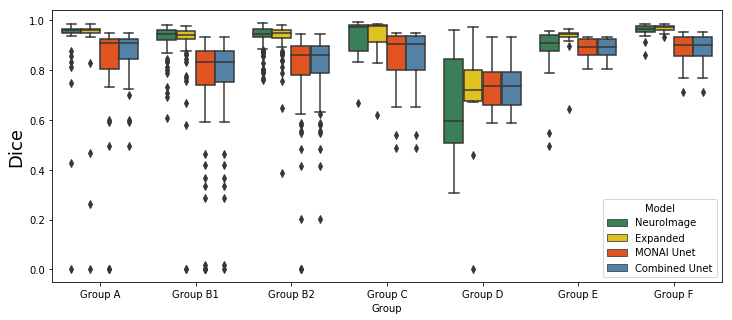

In [18]:
import pandas as pd

pd1 = pd.DataFrame(data={'Group': 'Group A', 'Dice': dice_groupA['guotai'], 'Model': 'NeuroImage'})
pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['expanded'], 'Model': 'Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['guotai'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['expanded'], 'Model': 'Expanded'}))

pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['basic_unet'], 'Model': 'MONAI Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['basic_unet'], 'Model': 'MONAI Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['basic_unet'], 'Model': 'MONAI Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['basic_unet'], 'Model': 'MONAI Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['basic_unet'], 'Model': 'MONAI Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['basic_unet'], 'Model': 'MONAI Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['basic_unet'], 'Model': 'MONAI Unet'}))

pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['combine_unet'], 'Model': 'Combined Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['combine_unet'], 'Model': 'Combined Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['combine_unet'], 'Model': 'Combined Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['combine_unet'], 'Model': 'Combined Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['combine_unet'], 'Model': 'Combined Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['combine_unet'], 'Model': 'Combined Unet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['combine_unet'], 'Model': 'Combined Unet'}))

fig = plt.figure(figsize=(12, 5))
b1 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd1, palette=['seagreen', 'gold', 'orangered', 'steelblue'])
b1.set_ylabel('Dice', fontsize=18)

Text(0, 0.5, 'Dice')

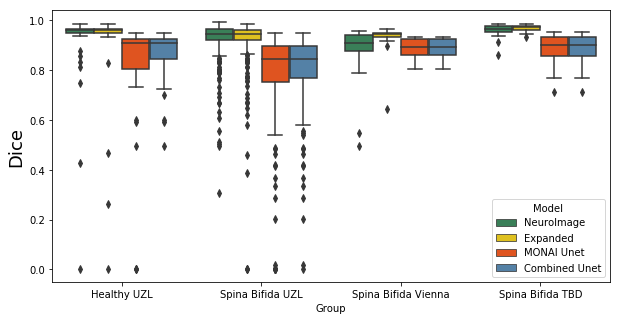

In [19]:
pd2 = pd.DataFrame(data={'Group': 'Healthy UZL', 'Dice': dice_groupA['guotai'], 'Model': 'NeuroImage'})
pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['expanded'], 'Model': 'Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['guotai'], 'Model': 'NeuroImage'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['expanded'], 'Model': 'Expanded'}))

pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['basic_unet'], 'Model': 'MONAI Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['basic_unet'], 'Model': 'MONAI Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['basic_unet'], 'Model': 'MONAI Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['basic_unet'], 'Model': 'MONAI Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['basic_unet'], 'Model': 'MONAI Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['basic_unet'], 'Model': 'MONAI Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['basic_unet'], 'Model': 'MONAI Unet'}))

pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['combine_unet'], 'Model': 'Combined Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['combine_unet'], 'Model': 'Combined Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['combine_unet'], 'Model': 'Combined Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['combine_unet'], 'Model': 'Combined Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['combine_unet'], 'Model': 'Combined Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['combine_unet'], 'Model': 'Combined Unet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida TBD', 'Dice': dice_groupF['combine_unet'], 'Model': 'Combined Unet'}))

fig2 = plt.figure(figsize=(10, 5))
b2 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd2, palette=['seagreen', 'gold', 'orangered', 'steelblue'])
b2.set_ylabel('Dice', fontsize=18)

In [ ]:
for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupA[k] == 0), axis=-1)
    print([dice_groupA['subj_id'][i] for i in idx])


In [ ]:
for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupB1[k] == 0), axis=-1)
    print([dice_groupB1['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupB2[k] == 0), axis=-1)
    print([dice_groupB2['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupC[k] == 0), axis=-1)
    print([dice_groupC['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupD[k] == 0), axis=-1)
    print([dice_groupD['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupE[k] == 0), axis=-1)
    print([dice_groupE['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupF[k] == 0), axis=-1)
    print([dice_groupF['subj_id'][i] for i in idx])

In [ ]:
dice_groupA['expanded'][np.squeeze(np.argwhere(dice_groupA['basic_unet'] == 0), axis=-1)]

In [ ]:
# print some cases to check
def print_cases_to_check(dice_dict, group, thr_diff=0.3):
    print(group)
    idx_over = np.argwhere(np.abs(dice_dict["difference"]) > thr_diff)
    idx_over = np.asarray(idx_over)
    [print(dice_dict["subj_id"][i], dice_dict["guotai"][i], dice_dict["retrained"][i]) for i, in idx_over]

print_cases_to_check(dice_groupA, 'Group A')
print_cases_to_check(dice_groupB1, 'Group B1')
print_cases_to_check(dice_groupB2, 'Group B2')


In [ ]:
sid = 'a06_04'
idx = np.argwhere(np.array(dice_groupA['subj_id']) == sid)
print(idx)
print("**** {} ****".format(sid))
print("Guotai = {}".format(dice_groupA['guotai'][idx]))
print("Expanded = {}".format(dice_groupA['expanded'][idx]))
print("MONAI = {}".format(dice_groupA['basic_unet'][idx]))

In [ ]:
dice_thr = 0.7
tot = len(dice_groupB2['subj_id'])
print("Total number of images in group: {}\n".format(tot))

for k in ['guotai', 'expanded', 'basic_unet']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupB2[k] < dice_thr), axis=-1)
    print([dice_groupB2['subj_id'][i] for i in idx])
    print("Percentage of cases: {}%\n".format(100*len(idx)/tot))